<a href="https://colab.research.google.com/github/a-forty-two/DataSetsForML/blob/master/15_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

airlinepassengers.csv  sample_data


     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


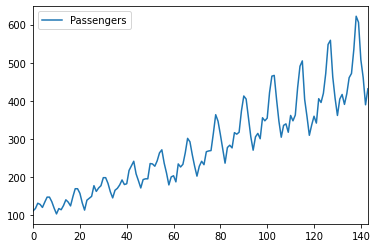

In [5]:
import pandas as pd
fl = pd.read_csv('airlinepassengers.csv', header=0)
print(fl.head())
import matplotlib.pyplot as plt
fl.plot()
plt.show()

In [0]:
# REGRESSION PROBLEM 
# REGRESS? No. of passengers!
# Clearly there are some holiday periods during which people don't travel, hence the rise and drop in graph
# but clearly, the no. of parrengers over the years is rising 
# LSTM -> 3 gates -> INPUT GATE , Output Gate , FORGET GATE 
# Forget Gate -> Logistic Sigmoid is multiplied to your data. This renormalizes your data in a way that very old 
# data normalizes to 0. Hence, the old data is forgotten.

import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(42)
# initialize the randomness inside numpy 

In [15]:
#fl.values.astype('float32')
data = fl.set_index('Month')
unnorm_x = data.values.astype('float32')
unnorm_x[:5]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.]], dtype=float32)

In [17]:
# MinMax custom scaler 
scaler = MinMaxScaler(feature_range=(0,1))
x = scaler.fit_transform(unnorm_x)
x[:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

In [48]:
# build train/test datasets 
# PLEASE REMEMBER NOT TO USE TRAINTESTSPLIT OR ANYTHING THAT LEADS TO SHUFFLING DATA
# This is time-series so order matters
print(len(x))
trainsize = int(0.7 * len(x))
testsize = len(x) - trainsize 
trainx, testx = x[:trainsize,:], x[trainsize:len(x),:]
# from beginning till trainsize excluding trainsize -> training
# from trainsize till len(trainsize) excluding len(trainsize) -> elements are 0 indexed, so the last element
# captured is len(trainsize)-1  
print(len(trainx))
print(len(testx))

144
100
44


In [49]:
trainx[:10]


array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753]], dtype=float32)

Asssume time series data was 1 3 4 5 6 7
So basically, we could arrange our output as 

Input      1 3 4 5 6 

Output     3 4 5 6 7

In [50]:
# write the logic of this conversion as function because it needs to be repeated for train/test or even 
# validation set if you had one

def builder(data, lookback=1):
   x,y = [], []
   for i in range(len(data)-lookback-1):
     xtemp = data[i:i+lookback,0]
     x.append(xtemp)
     y.append(data[i+lookback,0])
   return np.array(x),np.array(y)

trainx, trainy = builder(trainx, 1)
testx, testy = builder(testx, 1)
print(trainx[:10])
print(trainy[:10])

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]]
[0.02702703 0.05405405 0.04826255 0.03281853 0.05984557 0.08494207
 0.08494207 0.06177607 0.02895753 0.        ]


In [51]:
# reshape them into a common shape for tensors if they are in diff shapes 
print(trainx.shape)
print(trainy.shape)
print(testx.shape)
print(testy.shape)
trainx = np.reshape(trainx, (trainx.shape[0], 1, trainx.shape[1])) # MATRIX for LSTM 
testx = np.reshape(testx, (testx.shape[0], 1, trainx.shape[1])) 
print(trainx.shape)
print(trainy.shape)
print(testx.shape)
print(testy.shape)
# Sequence is the extra dim added 

(98, 1)
(98,)
(42, 1)
(42,)
(98, 1, 1)
(98,)
(42, 1, 1)
(42,)


In [0]:
# let's build the model
lookback = 1
lstm_dim =4
model = keras.Sequential()
model.add(keras.layers.LSTM(lstm_dim, input_shape=(1,lookback)))
model.add(keras.layers.Dense(1)) # Regression 
# classification-> 2, activation=sigmoid

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae']) # metrics are checked for early stopping


In [53]:
model.fit(trainx, trainy, epochs=100, batch_size=1, verbose=0)

In [54]:
trainpredictions = model.predict(trainx)
testpredictions = model.predict(testx)
# MinMax can be reversed
trainpredictions = scaler.inverse_transform(trainpredictions)
testpredictions = scaler.inverse_transform(testpredictions)
trainy = scaler.inverse_transform([trainy])
testy = scaler.inverse_transform([testy])
print(trainpredictions[:5])
print(trainy[:5])


[[121.285675]
 [126.65339 ]
 [139.30338 ]
 [136.57845 ]
 [129.34962 ]]
[[117.99999916 131.99999879 129.00000163 120.99999632 135.00000368
  147.99999397 147.99999397 136.00000531 119.00000078 103.99999952
  117.99999916 115.00000199 125.99999674 140.99999801 135.00000368
  125.00000283 148.9999956  169.99999891 169.99999891 157.99999481
  133.00000042 114.00000036 139.99999638 145.00000452 149.99999723
  177.9999965  163.00000295 172.00000217 177.9999965  198.99999982
  198.99999982 184.00000627 162.00000133 146.00000615 165.9999924
  171.00000054 179.99999976 193.00000549 181.00000139 183.00000464
  217.99999988 230.00000398 241.99999264 209.00000066 191.00000223
  172.00000217 194.00000712 195.99999493 195.99999493 235.99999831
  234.99999668 229.00000235 242.99999427 263.99999759 272.00001061
  236.99999994 211.00000392 179.99999976 201.00000308 203.99999252
  187.99999735 234.99999668 226.9999991  233.99999506 263.99999759
  301.99999771 292.99999849 259.00000488 229.00000235 203.0

In [55]:
trainscore = math.sqrt(mean_squared_error(trainy[0], trainpredictions[:,0]))
testscore = math.sqrt(mean_squared_error(testy[0], testpredictions[:,0]))
print(trainscore)
print(testscore)

23.337104790976444
49.19320845067039


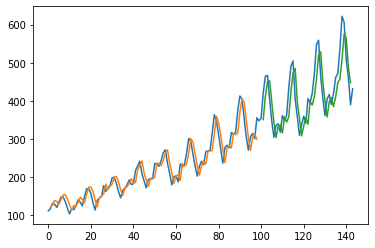

In [60]:
# shift predictions 1 step for training so that plots are visibly comparable 
trainPlot = np.empty_like(x) # returns an empty array of exactly same shape and size
trainPlot[:,:] = np.nan # nullify all other positions (the ones we want to print we'll add to this)
trainPlot[lookback:len(trainpredictions)+lookback,:] = trainpredictions # trainP is added to be printed
testPlot = np.empty_like(x)
testPlot[:,:] = np.nan
testPlot[len(trainpredictions)+(lookback*2)+1:len(x)-1,:] = testpredictions # len(data) + lookback*2 + 1
# to fix the one-step ahead error that i had assumed while plotting training data 
plt.plot(scaler.inverse_transform(x)) # original graph
plt.plot(trainPlot)

plt.plot(testPlot)

In [0]:
# SARIMAX -> Seasonal -> Auto Regression, Integrated Seasons and Moving Averages 
# 3 algos across -> The overall preiod on the data, the trend on the data, the residue left 
# 9 algorithms -> with and without season 
# (Season, P,T,R),(AR,I,MA) -> few possible 0 and 1 combinations of algos could have given best predictions
# (1,0,1,1),(1,0,1) -> example. We selected best algo combination through GridSearch 
# then we used the best hyperparam combination and generated predictions 
# LONG, tiring method, high error

# LSTM -> LSTM + 1 dense -> all you need in most cases 
# FASTER, much lesser error 

# if NN is not possible, use SARIMAX. 
# else use both SARIMAX and LSTM, and see which is better
